In [1]:
import numpy
%pylab inline
import matplotlib as mpl
mpl.rc("savefig", dpi=120)
import os
numpy.set_printoptions(precision=1)
import time
np.set_printoptions(precision=3)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import interp1d
def BE(**kwargs):
    Nx=kwargs.pop('Nx',30);Nt=kwargs.pop('Nt',100);T=kwargs.pop('T',None)
    D=kwargs.pop('D',1.1e-8);I=kwargs.pop('I',None);G=kwargs.pop('G',None)
    ku=kwargs.pop('ku',None);kd=kwargs.pop('kd',None);ks=kwargs.pop('ks',None)
    L=kwargs.pop('L',2e-5);PLOT=kwargs.pop('PLOT',False)
    saveU=kwargs.pop('saveU',None);Uinit=kwargs.pop('Uinit',None)
#------------------------------------------------------------------------------ 
    ku = 2*ku; kd = 2*kd # if this is applied, result is same with TMAP7. Why?
#------------------------------------------------------------------------------    
    G = G*ks
    if len(np.where(G<0)[0]): 
        return {'time':np.linspace(0,T,Nt+1),'pdp':np.zeros(Nt+1)}
    start = time.clock()
    x = np.linspace(0, L, Nx+1)       # mesh points in space
    t = np.linspace(0, T, Nt+1)       # mesh points in time
    if I: u_1 = np.array([I(i) for i in x]) # initial concentration
    else: u_1 = np.copy(Uinit)
    dx=x[1]-x[0]; dt=t[1]-t[0]
    F = D*dt/dx**2
    inlet = []; outlet = []
    inlet.append(ku*u_1[0]**2)
    outlet.append(kd*u_1[Nx]**2)
    u = np.zeros(Nx+1)
    if saveU: Usave = np.zeros((Nt+1,Nx+1),float)
    if saveU: Usave[0] = u_1
    if PLOT: plt.plot(x/1e-6,u_1,'k-',lw=4)
    color_idx = np.linspace(0,1,Nt)
    teta1 = D/(ku*dx)
    teta2 = D/(kd*dx)
    for n in range(0, Nt):
        #calculate u[1] and u[Nx-1] using explicit stencil
        g0 = F*u_1[0]+(1-2*F)*u_1[1]+F*u_1[2]
        gL = F*u_1[Nx-2]+(1-2*F)*u_1[Nx-1]+F*u_1[Nx]
        #put 1 for u[0] and u[Nx-1] in A
        A = diags(diagonals = 
                  [[0]+[-F for i in range(Nx-1)],
                  [1]+[1.+2.*F for i in range(Nx-1)]+[1],
                  [-F for i in range(Nx-1)]+[0]],
                  offsets=[1, 0, -1],shape=(Nx+1, Nx+1),format='csr')
        #in the b (for BE) put roots of the quadratic equation for the border.
        b = np.array([-teta1/2.+0.5*np.sqrt(teta1**2+4*teta1*g0+4*G[n]/ku)] +\
                     [i for i in u_1[1:Nx]]+\
                     [-teta2/2.+0.5*np.sqrt(teta2**2+4*teta2*gL)])
        #solve SLE
        u[:] = spsolve(A,b)
        u'Instead of u**2 put u*a, where a - u from previous step'
        for _ in range(3):
            a0 = u[0]; aL = u[Nx]
            A = diags(diagonals = 
                      [[-D/dx]+[-F for i in range(Nx-1)],
                       [D/dx+ku*a0]+[1.+2.*F for i in range(Nx-1)]+[D/dx+kd*aL],
                       [-F for i in range(Nx-1)]+[-D/dx]],
                      offsets=[1, 0, -1],shape=(Nx+1, Nx+1),format='csr')
            b = np.array([G[n]] +\
                         [i for i in u_1[1:Nx]]+\
                         [0])
            u[:] = spsolve(A,b)                   
        u_1, u = u, u_1
        inlet.append(ku*u_1[0]**2)
        outlet.append(kd*u_1[Nx]**2)
        if PLOT: plt.plot(x/1e-6,u_1,'.-',color = plt.cm.jet(color_idx[n])) # @UndefinedVariable
        if saveU: Usave[n+1] = u_1
        
    if PLOT:
        font = {'family':'Times New Roman','weight':'heavy','size': 25}
        plt.rc('font',**font)
        plt.rcParams.update({'mathtext.default':  'regular' })
        ax = plt.gca()
        ax.set_xlim(0,L/1e-6)
        ax.set_xlabel('x ($\mu m$)',fontweight = 'heavy')
        ax.set_ylabel('concentration ($m^{-3}$)',fontweight = 'heavy')
        sf = os.path.join(os.path.expanduser('~'),
                          'Desktop','Stencils','concentraion.png')# %(F))
        plt.savefig(sf,dpi = 300, bbox_inches = 'tight')
    end = time.clock()
    result = dict()
    result.update([('reflected',inlet),('pdp',outlet),('time',t),
                   ('concentration',u_1),('calctime',end-start)
                   ])
    if saveU: return Usave, [t,outlet]
    else: return result

In [3]:
def parameters():
    u'''initial parameters for the fit'''
    Nx=30;Nt=100;T=1000.;Tend=705.;D=1.1e-8;L=2e-5;ku=1e-33;kd=2e-33;ks=1e19
    PLOT=False;Uinit=np.zeros(Nx+1);G=np.zeros(Nt+1);I=None
    kwargs = dict()
    kwargs.update([('Nx',Nx),('Nt',Nt),('T',T),('D',D),('Tend',Tend),('L',L),
                   ('I',I),('G',G),('ku',ku),('kd',kd),('ks',ks),('PLOT',PLOT),
                   ('Uinit',Uinit)
                   ])
    return kwargs  

12.0
[1.048]


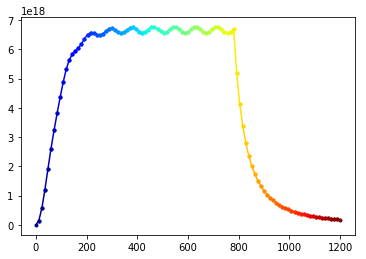

In [4]:
pm = parameters()
Nt=pm.get('Nt');Nx=pm.get('Nx');T=pm.get('T');Tend=pm.get('Tend')
Nt = 100; T = 1200.; Tend = 800.
tm = np.linspace(0, T, Nt+1)
dt = tm[1]-tm[0]
print dt
tend = int(Nt/T*Tend)-1
G = np.array([1+0.05*np.sin(ll*.3) for ll in np.linspace(0,300,Nt+1)])
G[tend:] = 0
stp=1
U = np.zeros(Nx+1)
#[N*stp:N*stp+stp+1]
R = range(Nt)
R = range(100)
clrs = np.linspace(0,1,len(R))
for N in R:
    Nt_stp = 1; T_stp = dt; Tend_stp = dt
    tm = np.linspace(0, T_stp, Nt_stp+1)
    G_stp = np.linspace(G[N*stp],G[N*stp+stp],Nt_stp)
    pm.update([('G',G_stp),('T',T_stp),('Tend',Tend_stp),('Nt',Nt_stp),('Uinit',U)])
    res = BE(**pm)
    pdp = res.pop('pdp'); tm = res.pop('time')
    U = res.pop('concentration')
    plt.plot(tm+N*stp*dt,pdp,'.-',color=plt.cm.jet(clrs[N]))
N = 30
print np.linspace(G[N*stp],G[N*stp+stp],Nt_stp)

In [5]:
print np.linspace(1.,.5,2)

[1.  0.5]


1.0 10.0 5 100


(-0.1, 1.1)

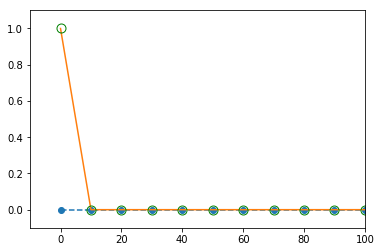

In [6]:
pm = parameters()
Nt = pm.get('Nt',None)
T = pm.get('T',None)
G = np.zeros(Nt+1)
tm = np.linspace(0,T,Nt+1)
plot(tm,G,'o--')
dt1 = 5
dt = tm[1]-tm[0]
stp = dt1//dt+1
print stp,dt,dt1,Nt
N = 0
G[int(N*stp):int(N*stp+stp)] = 1
plot(tm,G,'o-',mfc='none',mec='g',ms=9)
xlim(-10,100)
ylim(-.1,1.1)

In [7]:
G[3] = -2
if len(np.where(G<0)[0]): print 'negative'

negative


In [8]:
print type(G)
print G[10]
print G[:10]
print range(0,1)

<type 'numpy.ndarray'>
0.0
[ 1.  0.  0. -2.  0.  0.  0.  0.  0.  0.]
[0]


In [9]:
a = np.linspace(1,10,10)
print a
print a[1:2]

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[2.]
